In [4]:
%load_ext autoreload
%autoreload 2

from ivlib.utils import *
from modelsimu import *
import pandas as pd
import matplotlib.pyplot as plt
import copy

margins_begone()

Yessai! J'ai presque un modèle qui *fitte* à peu près correctement les données réelles, du coup je vais bientôt pouvoir écrire un article qui donne l'impression que j'y suis arrivé du premier coup! En attendant, quelques nuggets:

D'abord, quelques sources (nota: je ne m'intéresse qu'à la France là):

- Nombre de morts par jour: https://www.worldometers.info/coronavirus/country/france/ c'est pas la source primaire, mais c'est la plus facile à scrapper.
- Taux de mortalité de 0.66%, durée de l'incubation, délai entre les premiers symptomes et la mort: https://urgences-serveur.fr/mise-au-point-quotidienne-sur-le-covid-19.html?lang=fr
- Nombre de patients en réanimation : https://www.data.gouv.fr/fr/datasets/chiffres-cles-concernant-lepidemie-de-covid19-en-france/  (quelques dates manquantes à remplir)


# Première tambouille: retrouver le nombre de cas réels à partir du nombre de décès

Partant du principe que notre politique de tests manque beaucoup de cas et évolue probablement avec le temps, je me propose de simplement regarder la gueule de l'épidémie en reconstruisant le nombre de cas à posteriori. On sait que 0.66% des malades meurent (et on le sait grâce à des études qui se basent sur des tests sérologiques d'une population touchée, pas juste des test des dépistage au hasard) et on sait que la maladie met 22 jours de la contamination au décès. Ça donne donc:

In [13]:
death_dates= ["Feb 15","Feb 16","Feb 17","Feb 18","Feb 19","Feb 20","Feb 21","Feb 22","Feb 23","Feb 24","Feb 25","Feb 26","Feb 27","Feb 28","Feb 29","Mar 01","Mar 02","Mar 03","Mar 04","Mar 05","Mar 06","Mar 07","Mar 08","Mar 09","Mar 10","Mar 11","Mar 12","Mar 13","Mar 14","Mar 15","Mar 16","Mar 17","Mar 18","Mar 19","Mar 20","Mar 21","Mar 22","Mar 23","Mar 24","Mar 25","Mar 26","Mar 27","Mar 28","Mar 29","Mar 30","Mar 31","Apr 01","Apr 02","Apr 03","Apr 04","Apr 05","Apr 06","Apr 07","Apr 08","Apr 09","Apr 10","Apr 11","Apr 12","Apr 13","Apr 14","Apr 15","Apr 16","Apr 17","Apr 18","Apr 19","Apr 20","Apr 21","Apr 22","Apr 23","Apr 24","Apr 25"]

total_deaths = [1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,3,4,4,7,9,16,19,30,33,48,61,79,91,127,148,175,264,372,450,562,674,860,1100,1331,1696,1995,2314,2606,3024,3523,4032,5387,6507,7560,8078,8911,10328,10869,12210,13197,13832,14393,14967,15729,17167,17920,18681,19323,19718,20265,20796,21340,21856,22245,22614]
death_rate = 0.0066
ttd=22
case_estimated = np.array(total_deaths)[ttd:]/death_rate

/home/yves/.local/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


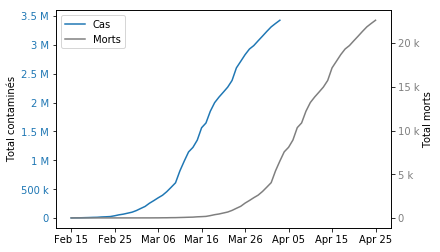

In [89]:
inds = list(range(0,80,10))
fig = plt.figure()
plt.plot(case_estimated, label="Cas")
plt.axes().yaxis.set_major_formatter(matplotlib.ticker.EngFormatter(unit=''))
plt.axes().yaxis.set_tick_params(labelcolor="C0")
plt.xticks(ticks=inds, labels=[death_dates[i] for i in inds])
plt.ylabel("Total contaminés")
ax2 = plt.axes().twinx()
ax2.plot(total_deaths, color="C7", label="Morts")
ax2.yaxis.set_tick_params(labelcolor="C7")
ax2.yaxis.set_major_formatter(matplotlib.ticker.EngFormatter(unit=''))
ax2.set_ylabel("Total morts")
fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax2.transAxes)

"T'as bougé la courbe vers la gauche en fait, rah quel génie!" 

Ouais, bon, ok. Le problème de cette approche c'est que les infos ont 22 jours de retard, mais ça nous donne une échelle du nombre de personnes qui ont été touchées (comprenant personnes contagieuses et personnes guéries). On était probablement autours de 3.5 millions en France au 4 avril.


# Deuxième tambouille: mesurer l'efficacité du confinement

Une des choses que nous permet cette évaluation, c'est de retrouver la vitesse à laquelle l'épidémie se transmet, chaque jour. Chaque jour, on regarde combien de nouveaux cas sont créés, par cas existant. Ça nous donne le facteur beta que j'utilisais dans mon modèle théorique, du post précédent.

Text(0.5, 1.0, 'Nouveaux cas/cas totaux')

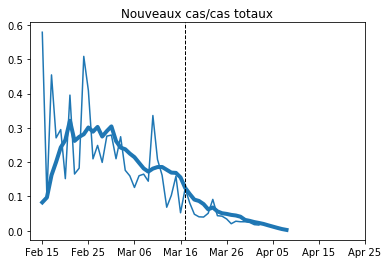

In [87]:
td = np.array(case_estimated)
betas=(td[1:]-td[:-1])/td[:-1]
plt.plot(betas, label="beta")
plt.plot(np.convolve(betas, np.ones(7)/7), linewidth=4, label="beta", color="C0")
plt.axvline(x=31, color="black", linestyle="--", linewidth=1)
plt.xticks(ticks=inds, labels=[death_dates[i] for i in inds[:]])
plt.title("Nouveaux cas/cas totaux")



Le début de la courbe est moche parce qu'on a peu de morts mais devient plus régulière par la suite. Je vous conseille d'ignorer ce qui se passe avant le 25 février. J'ai ajouté une courbe lissée sur 7 jours flottants pour voir les tendances et le pointillé correspond au début du confinement. Au passage c'est la chose que j'ai mis le plus de temps à debugger. Au début j'avais modélisé le confinement comme un seuil brutal: le 17 mars, changement brutal de beta. Et ça ne correspond en fait pas du tout à la réalité. En fait, dés le début de mars, des mesures efficaces ont été prise: annulation de gros événements, les écoles de plusieurs clusters ont été fermées, des rencontres sportives reportées puis annulées... Le confinement correspond à une décrue finale.

Cette courbe me rend plutôt optimiste en fait. Elle vient un peu à l'encontre de la version qu'on peut lire et qui fait des Français un peuple têtu incapable de prendre conscience de la situation. La prise de conscience a été progressive, mais elle a commencé tôt.

# Teaser

La prochaine fois, on parlera saturation hospitalière et immunité de groupe! Sortez couverts! (ou ne sortez pas, en fait).

In [92]:
rea_dates = ['2020-01-28', '2020-01-29', '2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-07', '2020-02-08', '2020-02-09', '2020-02-10', '2020-02-12', '2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21', '2020-02-23', '2020-02-24', '2020-02-25', '2020-02-26', '2020-02-27', '2020-02-28', '2020-02-29', '2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16', '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20', '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29', '2020-03-30', '2020-03-31', '2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05', '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09', '2020-04-10', '2020-04-11', '2020-04-12', '2020-04-13', '2020-04-14', '2020-04-15', '2020-04-16', '2020-04-17', '2020-04-18', '2020-04-19']
rea_values = [1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 9, 9, 9, 9, 15, 23, 39, 45, 45, 66, 86, 105, 129, 129, 300, 300, 300, 699, 931, 1122, 1297, 1525, 1746, 2082, 2516, 2827, 3375, 3787, 4273, 4632, 5107, 5565, 6017, 6399, 6662, 6838, 6978, 7072, 7131, 7148, 7066, 7004, 6883, 6845, 6821, 6730, 6457, 6248, 6027, 5833, 5744]
rea_values = rea_values[15:]
rea_dates[15]

'2020-02-15'

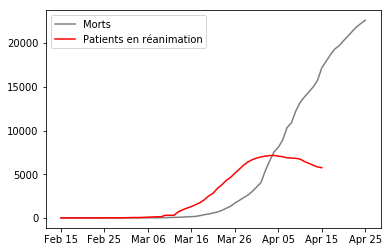

In [100]:
plt.plot(total_deaths, label="Morts", color="C7")
plt.plot(rea_values, label="Patients en réanimation", color="RED")
plt.xticks(ticks=inds, labels=[death_dates[i] for i in inds[:]])
plt.legend()